#  Оценка стоимости  и типа трансмиссии по данным продаж автомобилей на вторичном рынке Молдавии

# Часть 2. Алгоритмы своими руками

## Линейная регрессия своими руками

проведем линейную регрессию только по численным столбцам. Их у нас будет 3. <br>
ВВедем модель целевой переменной как
$$ \begin{align*}
   &y_i = \sum_{j=0}^{2}x_{ij}w_j +\eta_i \\ 
   \text{или так }& y_i = x_{i0}\cdot w_0 + x_{i1}\cdot w_1 + x_{i2}\cdot w_2 + \eta_i \\
   \text{или так }& y_i = X_i W^T + \eta_i , 
   \end{align*}
   $$
где <ul>
    <li> $y_i$ - целевой показаль предсказания для $i$ записи в наборе данных;
    <li> $X_i  = (x_{i0},x_{i1},x_{i2}) = \{x_{ij}\}_{j=0}^{2}$ - набор входных параметров для $i$ результата ($X_i^T$ - траспонированная строка (столбец));
    <li> $W = (w_0,w_1,w_2) = \{w_{j}\}_{j=0}^{2}$ - набор весовых параметров, которые мы должны подобрать в моделе;
    <li> $\eta_i$ - некоторый набор случайных (не объясняемых нашей моделью, остаточных) значений, мы будем считать их случайных шумом.  </ul>   
    <br> тогда наша регрессионная модель будет иметь вид
        $$ \begin{align*}
   &\hat{y}_i = \sum_{j=0}^{2}x_{ij}w_j  \\ 
   \text{или так }& \hat{y}_i = x_{i0}\cdot w_0 + x_{i1}\cdot w_1 + x_{i2}\cdot w_2  \\
   \text{или так }& \hat{y}_i = X_i W^T, 
   \end{align*}
   $$
где <ul> 
    <li> $\hat{y}_i $ - результат предсказания для $i$ записи в наборе данных.   </ul>   
        
Для начала разобъем данные на тест и тренировочные

В качестве данных возьмем только численные колонки.  Полученные колонки мы разделим на целевую и исходные данные. Затем разделим данные на тестовую и тренировочную выборки. Мы приведем все численные колонки к одному масштабу при помощи мини-максного преобразования. При этом коэффициенты преобразования получим для тренировочных данных, а для тестовых просто выполним преобразование с имеющимися коэффициентами. Преобразование выполняется следующим образом:
$$ X' = \frac{X - min(X)}{max(X) - min(X)},$$
где значения $min(X) и max(X) $ - это коэффициенты.

Загрузим наборы данынх

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns; 
sns.set()

try:
    import plotly
except:
    !pip install plotly
finally:
    import plotly.express as px

%matplotlib inline

import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_num = pd.read_csv("car_num.csv")
df_num = df_num.drop(columns = ['Unnamed: 0'])
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32074 entries, 0 to 32073
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32074 non-null  int64  
 1   Distance              32074 non-null  float64
 2   Engine_capacity(cm3)  32074 non-null  float64
 3   Price(euro)           32074 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1002.4 KB


In [3]:
df_se = pd.read_csv("car_se.csv")
df_se = df_se.drop(columns = ['Unnamed: 0'])
df_se.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32074 entries, 0 to 32073
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  32074 non-null  int64  
 1   Model                 32074 non-null  int64  
 2   Year                  32074 non-null  int64  
 3   Style                 32074 non-null  int64  
 4   Distance              32074 non-null  float64
 5   Engine_capacity(cm3)  32074 non-null  float64
 6   Fuel_type             32074 non-null  int64  
 7   Transmission          32074 non-null  int64  
 8   Price(euro)           32074 non-null  float64
 9   km_year               32074 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 2.4 MB


In [4]:


X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

,0,1,2
22446,0.64,0.479896,0.353333
22447,0.74,0.465893,0.479167
22448,0.70,0.572360,0.333333
22449,0.70,0.581916,0.375000
22450,0.24,0.579916,0.000000


Введем функцию потрерь регрессии как квадрат разности между целевыми значениями и их предсказаниями 
$$ L(\hat{y}_i,y_i)=L_i= (\hat{y}_i-y_i)^2 = \left(\sum_{j=0}^{2}x_{ij}w_j-y_i\right)^2 = \left(X_i W^T-y_i\right)^2 , $$
где  $L_i$ - функция потерь для результата (предсказания) с номером $i$. <br>
Также введем функцию расчета (предсказания) значений predict.


In [5]:
def forward(weights, inputs):
    return inputs.dot(weights.T)

def loss_func(predicts, labels):
        return np.square(predicts - labels)  

Протестируем обе функции

In [6]:
weights = np.random.randn(X.shape[1])
print(weights)
yhat = forward(weights, X_train[0])
loss = np.sqrt(loss_func(yhat, y[0]))
print(yhat, y[0], loss)

[-0.03358058 -1.89786162 -0.89692826]
-1.783906219118447 7750.0 7751.783906219119


Посмотрим на график того как меняется функция потерь в зависимости от отклонения (мультипликативного) оценки результата от его истинного значения.

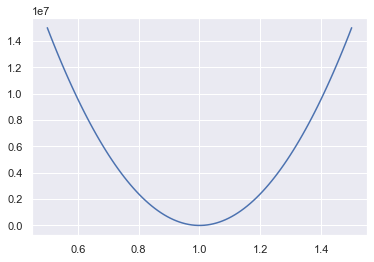

In [7]:
decline = np.linspace(start = 0.5, stop = 1.5,num = 100)
yhat = decline* y[0]
loss = loss_func(yhat, y[0])
plt.plot(decline,loss)

### Вопрос
1. назовите результат функции потерь если истинное значение 2, а оценка результата 4.<br>


Сразу омтетим, что нам потребуется не только сама фунция потерь, но и ее производная по набору оптимизируемых параметров $\{w_j\}$.   
    $$ \frac{\partial L_i}{\partial w_j} = 2\left(\sum_{j=0}^{2}x_{ij}w_j-y_i\right)x_{ij} = 2(\hat{y}_i - y_i)x_{ij}, $$
где  $\frac{\partial L_i}{\partial w_j}$ - частная производная функции $L_i$ по параметру $w_j$  <br>   
тогда по набору всех переменных мы получим производную вида:
$$\nabla_{W}L_i = 2\left ((\hat{y}_i-y_i)x_{i0}, 
(\hat{y}_i-y_i)x_{i1}, 
(\hat{y}_i-y_i)x_{i2} \right) = 2(\hat{y}_i-y_i)\odot X_i^T,  $$
 где <ul> 
    <li> $\nabla_{W}L_i$ - градиент, то есть набор частных производных функции $L_i$ по набору \{$w_j$\}.  
    <li> $\odot$ - операция поэлементного умножения (умножение Адамара)    

In [8]:
def grad_loss(predicts, labels, inputs):
    return 2*(predicts - labels)*inputs/inputs.size

Проведем расчет градиента ошибки

In [9]:
weights = np.random.randn(X.shape[1])
yhat = forward(weights, X_train[0])

grad = grad_loss(yhat, y[0], X[0])
print(grad)

[-1.03893442e+07 -1.00742025e+09 -9.29926384e+06]


### Вопрос
1. назовите результат градиента функции потерь если истинное и оцененное значения совпадают.<br>


### Вопрос
1. назовите результат градиента функции потерь если результат оценки 4, истинное значение 2, а входные данные (1,2,3).<br>


Опимизацию мы будем проводить методом граидентного спуска. <br>
По сути этот метод сводится к последовательному (итерационному) пересчету значений весовых параметров обратно значеням градиента ошибки (то есть в направлении, обратном направлению роста ошибки).
<br> обозначим номер итерации как  $t$, тогда выражение для обновления весовых параметров можно записать как: 

$$ W^t = W^{t-1}-\eta\nabla_{W}L(\hat{y}_i,y_i)=W^{t-1} - 2\eta (\hat{y}_i-y_i)\odot X_i^T  $$

где <ul>
<li> $\eta$ - коэффициент с которым изменяются значения весовых параметров - т.н. скорость обучения;



In [10]:
def update_weights(grad, weights, lerning_rate):
    return weights - lerning_rate*grad

теперь проведем обновление весовых параметров

In [11]:
lerning_rate = 0.01
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[  103894.86610008 10074202.52890103    92991.51202178]


### Вопрос
1. назовите обновление весовых параметров если результа и иситнное значение сопадают, а скорость обучения 0.02.<br>


Помимо того, чтобы обучать значения весовых параметров,  необходимо задать их начальные значения - то есть провести процедуру инициализации. Такую процедуру можно провести с использованием небольших случайных  значений. Разброс этих значений мы виберем как $\sqrt{weight.size}$

In [12]:
def weights_init(weights, random_state=42):
    if np.ndim(weights)<1:
        weights = np.zeros(weights)
        
    np.random.seed(random_state)
    return np.random.randn(*weights.shape)/np.sqrt(weights.size)

Также создадим процедуру обучения. Процедура будет повторять порцесс пересчета весов методом градиентного спуска заданое число раз (epochs).<br> 
Функция будет требовать на вход <ul>
    <li> $X$ - набор входных значений (т.н. батч ) в формате: $\textrm{число записей}\times\textrm{значения в записи}$;
    <li> $y$ - набор целевых переменных (labels);   
    <li> $weights$ - начальные значения весовых параметров;
    <li> $lr$ - скорость обучения;    
    <li> $epochs$   -  число эпох обучения.
        </ul>
Функция дает на выходе:<ul>
    <li> $weights$ - набор обученных весовых параметров;
    <li> $cost$    - график функции потерь.
 </ul>
Также отметим, что на практике мы можем обновлять весовые параметры не для кажого отдельного значения $i$, а для целого набора такхи значений, тогда более верное выражение будет выглядеть как

$$ W^t = W^{t-1}-\eta\frac{1}{M}\sum_{m=1}^{M-1}\nabla_{W}L(\hat{y}_i,y_i),  $$
где $M$ - объем выборки.        

In [13]:
def fit(X, y, weights, lr,  epochs=30):
    
    cost = np.zeros(epochs)
    for i in range(epochs): 
        
        grad = np.zeros(weights.shape);
        loss = 0;
        
        for m in range(X.shape[0]): 
            yhat  = forward(weights, X[m,:])
            grad += grad_loss(yhat,  y[m], X[m,:])
            loss += loss_func(yhat,  y[m])

        weights = update_weights(grad/X.shape[0],weights, lr)  
        cost[i] = loss/X.shape[0]
    
    return weights, cost

Протестируем обучение

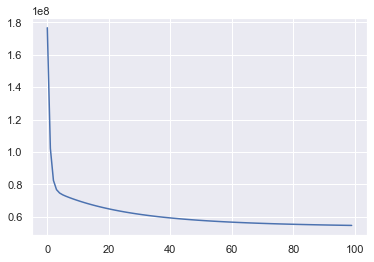

In [14]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit(X_train, y_train, weights, lr=0.9,  epochs=100)

plt.plot(cost)

Теперь проверим как точно предсказывает наша функция, для этого мы можем воспользоваться метрикой r2, метрика соотвествует относительной среднеквадратичной ошибке, она может быть расчитана как:
$$ 
R^2 = 1-\frac{\sum_{i=0}^{M-1}(y_i - \hat{y}_i)^2}{\sum_{i=0}^{M-1}(y_i - \mathrm{ev}(y))^2} = 1 - \frac{SS_{\rm res}}{SS_{\rm tot}},
$$
где <ul>
    <li> $SS_{\rm res} = \sum_{i=0}^{M-1}L_i = \sum_{i=0}^{M-1}(y_i - \hat{y}_i)^2 $ - суммма квадратов остатков, величина, характеризующая степень того на сколько наша модель не соотвествует нашим данным - то есть то, на сколько мы не можем объяснить нашей моделью наши данные;
    <li> $SS_{\rm tot}$ - дисперсия данных - то есть сумма квадратов разностей значений данных и их среднего значения;
    <li> $\mathrm{ev}(y) = \frac{1}{M}\sum_{i=0}^{M-1}y_i$ - среднее значение.    

In [15]:
def predict(weights, inputs):
    yhat = np.zeros(inputs.shape[0])
    
    for m in range(inputs.shape[0]):
        yhat[m] = inputs[m,:].dot(weights.T)
    
    return yhat

посмотрим как выглядят наши ответы на фоне реальных

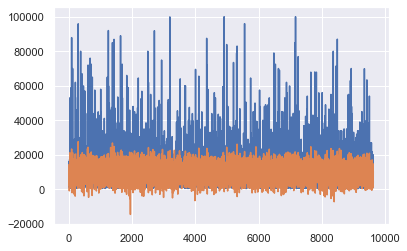

In [16]:
yhat = predict(weights, X_test)
plt.plot(y_test, label='original')
plt.plot(yhat, label='predicted')

In [17]:
def r2_score(weights, inputs, labels):
    predicts = predict(weights, inputs)
    return 1-np.sum(np.square(labels-predicts))/np.sum(np.square(labels-np.mean(labels)))

In [18]:
labels = np.array([1,2,3])
predicts = np.array([2,4,6])
1-np.sum(np.square(labels-predicts))/np.sum(np.square(labels-np.mean(labels)))

-6.0

In [19]:
r2_score(weights, X_test, y_test)

0.37921301248245987

###  вопрос
1. назовите значение ошбики r2 если истинные значения 1,2,3 а оцененные 2,4,6.<br>


На практике как правило, на каждой эпохе рассматривается не веся выборка, а только некоторая ее часть - т.н. батч (мини пакет). 

In [20]:
BATCH = 5000

def fit_SGD(X, y, weights, lr,  epochs=30, batch_size = BATCH, random_state = 42):
    
    np.random.seed(random_state)
    
    
    cost = np.zeros(epochs)
    for i in range(epochs): 
        
        grad = np.zeros(weights.shape);
        loss = 0;
        
        idx_batch = np.random.randint(0,X.shape[0],batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        y_batch   = np.take(y, idx_batch)

        
        for m in range(batch_size): 
            yhat  = forward(weights, x_batch[m,:])
            grad += grad_loss(yhat,  y_batch[m], x_batch[m,:])
            loss += loss_func(yhat,  y_batch[m])

        weights  = update_weights(grad/batch_size,weights, lr)  
        cost[i] =loss/batch_size
    
    return weights, cost

0.39981284011738194


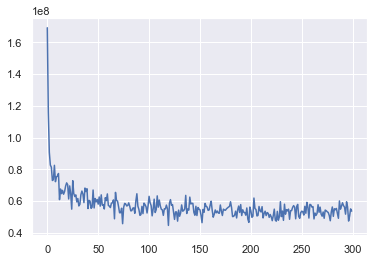

In [21]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit_SGD(X_train, y_train, weights, lr=0.7,  epochs=300)

plt.plot(cost)

print(r2_score(weights, X_test, y_test))

Теперь давайте объеденим все наши часть в один класс линейной регресии.
<br> При объединении мы сделаем две дополнительные модификации нашей модели.
<ul>
    <li> во-первых, введем в модель дополнительный член - смещение ($b$), тогда можно записать модель так:
        $$\begin{align*}
        &\hat{y}_i = \sum_{j=0}^{M-1}x_{ij}w_j+b \\
        \text{   или так: }&\hat{y}_i = \sum_{j=0}^{M}x_{ij}w_j, x_{i0} \equiv 1.
        \end{align*}$$
        обе запси формально равнозначны. <ul>
        при этом отметим, что градиент функции потерь по остаточному члену можно записать следующим образом:
        $$b^t = b^{t-1}-\eta\nabla_{b}L(\hat{y}_i,y_i)=b^{t-1} - 2\eta(\hat{y}_i-y)$$
        </ul>
        Мы будем использовать второй вариант, то есть объеденим веса и смещния, а к данным добавим столбец едениц.
<li> Во воторых запишем все обозначенные функции в один класс.
<li> В третьих проведем векторизацию в тех местах, где у нас стояли лишнии циклы.
    <br> В том числе отметим, что выражение для расчет суммарного градиента может быть записано векторно в следующей форме
    $$2\sum_{i=0}^{M-1}(\hat{y}_i-y_i)\odot X_i^T = 2 X_i^T(\hat{y}-y), $$ 
    где $\hat{y}, y$ - массивы значений оценок и целевых результатов.
    

In [22]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        # if both predefined
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
            #merge both together if it was not done! 
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            #merge both together if it was not done! 
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() #backward 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        # only for output
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6)):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

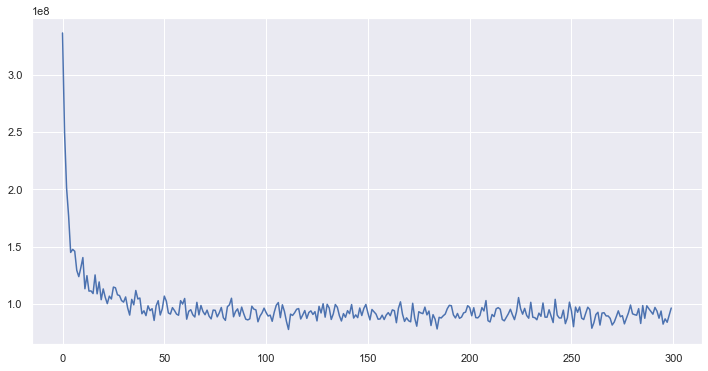

0.4983362240143835 0.483527889376391


In [23]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000, n_batches=1)
regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))



посмотрим веса

<BarContainer object of 3 artists>

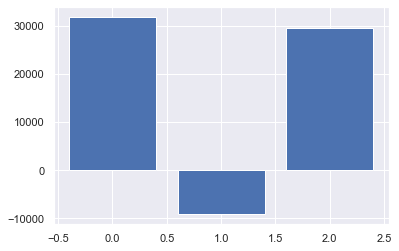

In [24]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)

## Регуляризация линейной регрессии

### Регуляризация Тихонова

Часто бывает так, что обычный градиентный спуск приводит к переобучению модели. Переобучение это ситуация, когда точность на обучающих данных значительно выше, чем на тестовых. В таких случаях также можно сказать, что данные плохо обусловлены - то есть любые небольшие изменения по отношению к тренировочной выборке приведут к большим изменениям в ответе модели. В целом это будет означать, что модель дает очень большой разброс результатов. Такой разброс может быть снижен при помощи различных техник регуляризации. Смысл использования таких техник сводится к тому, что при обучении модели к выражению обновления весовых параметров добавляется дополнительное условие. Например, можно добавить условие ограничение суммы квадратов весовых параметров. Такое предположение называется регрессией Тихонова или гребневой регрессией (а также L2 регуляризацией). Технически такая регуляризация соответствует предположению, что распределение результатов работы модели имеет вид нормального распределения. Такое предположение часто допустимо и оправдано.<br>
Регрессия Тихонова может быть записана в следующей форме:

$$ \begin{cases} 
L(\hat{y}_i,y_i)\to \min \\
\| W \|_2^2< \mathrm{const}
\end{cases}
\to L(\hat{y}_i,y_i) + \frac{\lambda}{2M}\sum_{j=1}^{N} W_j^2\to \min,
$$
где  <ul>
     <li> $ \| W \|_2^2 = \sum_{j=1}^{N} W_j^2$ - норма Фробениуса для вектора или матрицы;
     <li> $ \lambda $   - регуляризационный множетель;  
     <li> $N$ - размер вектора весовых параметров;
     <li> $M$ - объем выборки весовых параметров;   
    </ul>
Закон изменения весовых параметров для данной модели можно зписать как:
$$ W^t = W^{t-1}-\eta\frac{1}{M}\sum_{m=0}^{M-1}\nabla_{W}L(\hat{y}_i,y_i) + \frac{\lambda}{M}\sum_{j=1}^{N} W_j. $$
Запишем новую версию регрессии. Для этого запишем новый класс, наследующий от уже созданного и перепишем в нем методы `loss`     и `update`. Также отметим, что веса в регуляризации учитваются без смещения!

In [25]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l2_penalty = l2_penalty
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l2_term
                  
    
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*self.grad + l2_term  


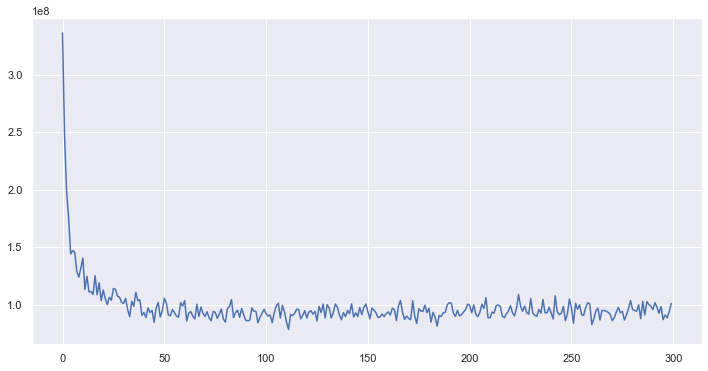

0.48656288875416986 0.45930804045571727


In [26]:
regr = RidgeRegression(learning_rate=0.5,epochs=300,batch_size=3000, l2_penalty = 0.003, n_batches=1)
regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

посмотрим веса

<BarContainer object of 3 artists>

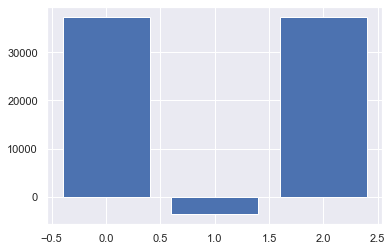

In [27]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)

### Регуляризация L1
В ряде случаев, когда разброс данных оказывается очень большим, регуляризации L2 может оказаться бесполезной или даже вредной. Дело в том, что в функции потерь мы учитываем веса в квадрате и большие колебания весовых параметров приведут к в квадрате большим колебаниям в значениях функции потерь. Часто эта ситуация является недопустимой. В таких случаях следует выбирать более устойчивые (робастные методы). Робастные методы могут быть менее точными, однако более стабильными. Одним из наиболее распространённых робастных методов является L1 регуляризация. В этом случае выражение для функции потерь может быть записано следующим образом:
$$ \begin{cases} 
L(\hat{y}_i,y_i)\to \min \\
\| W \|_1^1 \mathrm{const}
\end{cases}
\to L(\hat{y}_i,y_i) + \frac{\lambda}{2M}\sum_{j=1}^{N} W_j\to \min,
$$
где  <ul>
     <li> $ \| W \|_1^1 = \sum_{j=1}^{N} W_j$ - норма L1 для вектора или матрицы;
     <li> $ \lambda $   - регуляризационный множетель;  
     <li> $N$ - размер вектора весовых параметров;
     <li> $M$ - объем выборки весовых параметров;   
    </ul>
Закон изменения весовых параметров для данной модели можно зписать как:
$$ W^t = W^{t-1}-\eta\frac{1}{M}\sum_{m=0}^{M-1}\nabla_{W}L(\hat{y}_i,y_i) + \lambda. $$
Запишем новую версию регрессии. Для этого запишем новый класс, наследующий от уже созданного и перепишем в нем методы `loss`     и `update`.

In [28]:
class LassoRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
    
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        return np.square(yhat - y).mean() + l1_term
                  
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad + self.l1_penalty 

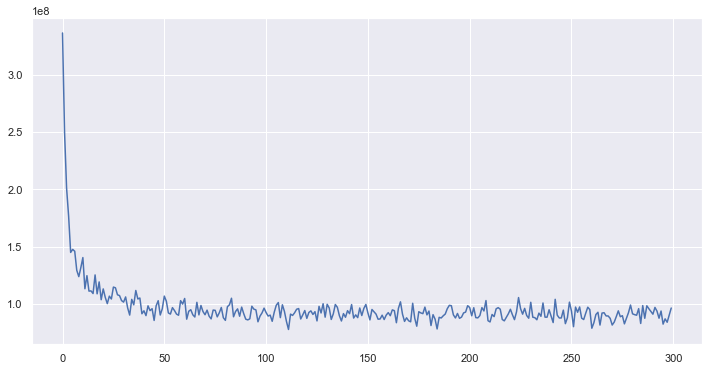

0.4983397484957135 0.48352768755823583


In [29]:
regr = LassoRegression(learning_rate=0.5,epochs=300,batch_size=3000, l1_penalty = 0.08, n_batches=1)
regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

посмотрим веса

<BarContainer object of 3 artists>

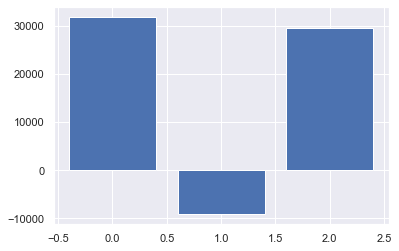

In [30]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)

### Эластичная регуляризация
Отметим, что во многих случаях неизвестно какая модель регуляризации окажется лучше, поэтому целисообразно использовать их обе вместе. Такая модель регуляризации называется эластической регуляризацией. Попробуем ее реализовать

In [31]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*self.grad + self.l1_penalty + l2_term

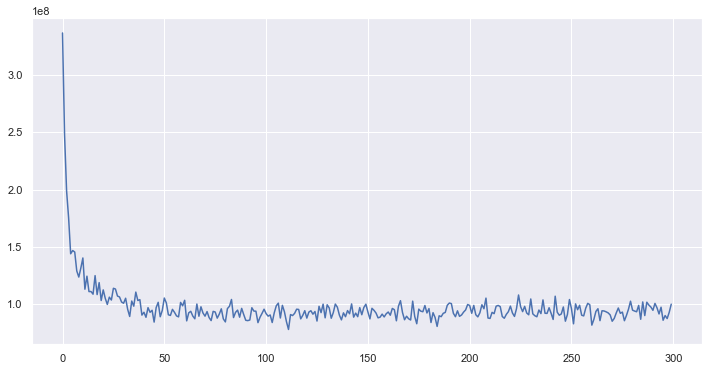

0.4892313042915978 0.4632799325768351


In [32]:
regr = ElasticRegression(learning_rate=0.5,epochs=300,batch_size=3000, l1_penalty = 0.08,l2_penalty = 0.0028, n_batches=1 )
regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

посмотрим веса

<BarContainer object of 3 artists>

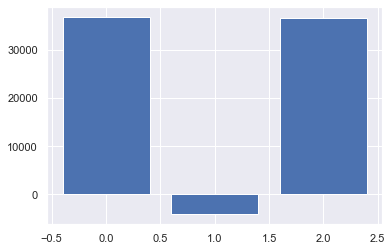

In [33]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)

###  Вопрос
1. посмотрите на значения весовых параметров в эластической регрессии, ответьте на вопрос, какая регуляризация в ней преобладает (L1, L2, никакая ).<br>


## Логистическая регрессия

Один из самых простых методов классификации — это логистическая регрессия. По существу, модель логистической регрессии представляет собой аналог линейной регрессии. Однако, если в случае линейной регрессии мы хотели провести линию через наши данные, то в случае логистической регрессии мы стремимся провести линию между двумя классами наших данных. Технически это сводится к тому, что введем функцию принятия решений для результата сопоставления наших данных и построенной линии.
Это можно описать как следующую модель:
$$ \hat{y}_i = \sigma \left(\sum_{j=0}^M w_jX_{ij}\right) \equiv \sigma \left(\sum_{j=1}^M w_jX_{ij}+b\right), $$
где <ul>
<li> $\sigma$ - функция принятия решений - функция активации;
<li> $ \hat{y}_i$ - результат принятия решений - класс экземпляра данных.
    </ul>
Из некоторых статистических выводов известно, что для такой модели необходимо выбрать функцию потерь следующего вида:
$$ L = -\frac{1}{M}\sum_{i=0}^{M-1}{y_i \log{\hat{y}_i}+(1-y_i)\log{(1-\hat{y}_i)}}$$

и следующий вид функции активации:
$$\sigma(z_i) = \frac{1}{1+\exp(-z_i)}, $$
где <ul>
    <li> $z_i = \sum_{j=0}^M w_jX_{ij} = X_iW^T$ - т.н. логит; 
     <li> тогда $\hat{y}_i =\sigma(X_iW^T) $.   </ul>
         
прежде чем записать выражение для градиента функции потерь запишем выражение для производной функции активации
$$ \sigma'(z_i) = \frac{\partial \sigma(z_i)}{\partial z_i} = (1-\sigma(z_i))\sigma(z_i) $$
Градиент функции потерь для одного элемента выборки может быть выражен следующим образом:
$$ 
\nabla_W L_i = 
-{
\left(\frac{y_i}{\sigma(X_iW^T)}-\frac{1-y_i}{1-\sigma(X_iW^T)}\right)\sigma'(X_iW^T)\odot X_i 
= -\left(y_i - \sigma(X_iW^T) \right)\odot X_i = -\left(y_i - \hat{y}_i\right)\odot X_i 
}
$$
Тогда правило обновления весовых параметров может быть записано как
$$ W^t = W^{t-1} + \eta\frac{1}{M}\sum_{i=0}^{M-1}\left(y_i - \hat{y}_i\right)\odot X_i.$$
Отметим, что данное выражение эквиваленто записанному для логистической регрессии с точностью до коэффициента $2$, поэтому мы учтем данный параметр путем замены $\eta \to \eta/2$.
<br>





рассмотрим графики функции активации сигмоид и ее производной

In [34]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z)) 

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z)) 

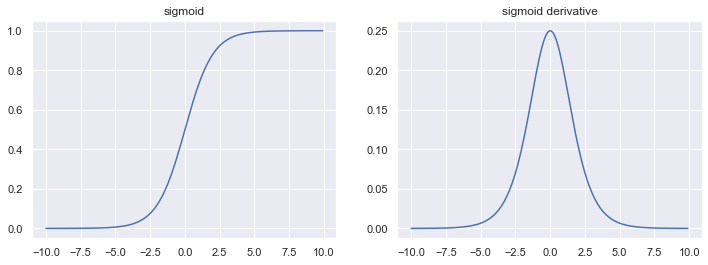

In [35]:
z = np.arange(-10,10,0.1)

plt.figure(figsize=(12,4))
plt.subplot(121); plt.plot(z,sigmoid(z)); plt.title('sigmoid')
plt.subplot(122); plt.plot(z,sigmoid_derivative(z)); plt.title('sigmoid derivative')
plt.show()

### Вопрос:
1. назовите значение функции сигмоид для z = 0 <br>


### Вопрос:
1. назовите значение  производной функции сигмоид для z = 0 <br>


Как правило, после расчета функции активации мы должны округлить значения до 0 или до 1. То есть до значения метки одного из классов. Такое округление можно сделать по заданному порогу результатов функции активации. Например, мы можем сказать, что если значение сигмоида больше 0.5 то пусть будет класс 1, а если меньше, то наоборот. Однако, на практике мы ставим более высокий порог, как правило 0.7 - 0.8. Запишем функцию определения класса.

Отметим, что в описанном смысле можно говорить о том, что результат сигмоида - это вероятность того, что аргумент функции (z) принадлежит одному из классов. Также отметим, что такой аргумент принято называть логит.



In [36]:
def to_class(logit, threshold = 0.7):
    return (logit>=threshold)*1

In [37]:
print( to_class(sigmoid(2.5), threshold = 0.7), ',',  to_class(sigmoid(-2.5), threshold = 0.7) )

1 , 0


Отметим, что для расчета функции потерь не следует пользоваться округлением до классов

### Вопрос:
1. Назовите к какому классу следует отнести результат функуии сигмоид для z = 5 <br>


### Вопрос:
1. Назовите к какому классу следует отнести результат функуии сигмоид для z = 0.1 если порог 0.5 <br>


### Вопрос:
1. Назовите к какому классу следует отнести результат функуии сигмоид для z = 0.0 если порог 0.2 <br>


Теперь рассмотрим функцию потерь. Отметим, что значениях логорифма мы ввели небольшую константу с целью исключить ошибку вида логорифм нуля.

In [38]:
_EPS_ = 1e-6
def loss(yhat, y):
    return -(y*np.log(yhat + _EPS_)+(1 - y)*np.log(1 - yhat + _EPS_)).mean()

для начала рассмотрим значение функции активации для предельных случаев значений вероятности.

In [39]:
print('ambiguity (yhat=0.5, y=1):\t %.3f'%loss(yhat=0.5, y=1))
print('ambiguity (yhat=0.5, y=0):\t %.3f'%loss(yhat=0.5, y=0))
print('zero class (yhat=0, y=0):\t %.3f'%loss(yhat=0.0, y=0))
print('first class(yhat=1, y=1):\t %.3f'%loss(yhat=1, y=1))
print('zero class error (yhat=0, y=1):\t %.3f'%loss(yhat=0.0, y=1))
print('first class error(yhat=1, y=0):\t %.3f'%loss(yhat=1, y=0))

ambiguity (yhat=0.5, y=1):	 0.693
ambiguity (yhat=0.5, y=0):	 0.693
zero class (yhat=0, y=0):	 -0.000
first class(yhat=1, y=1):	 -0.000
zero class error (yhat=0, y=1):	 13.816
first class error(yhat=1, y=0):	 13.816


### Вопрос:
1. Назовите предельное значение  ситуации flase positive <br>


### Вопрос:
1. Назовите предельную ошибку ситуации неопределенности <br>


Запишем все в один класс. Также добавим в функцию гребневую регуляризацию.

In [40]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty    = 0.0,
                 l2_penalty    = 0.0,
                 epochs        = 100, 
                 weights       = None, 
                 bias          = None, 
                 threshold     = 0.5,
                 batch_size    = 1000, 
                 n_batches     = None,
                 random_state  = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    
    #---------------------------------    
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term 
    
    #---------------------------------
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) 
    
    #---------------------------------
    def forward(self, X):        
        return self.sigmoid(self.weights.dot(X.T))
    
    #---------------------------------
    def to_class(self,logit):
        return (logit>=self.threshold)*1
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        
        if self.threshold:
            return self.to_class(yhat)
        else:
            return yhat
    #---------------------------------
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    
    #---------------------------------
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.4f'%(tp/total), end = '\t')
        print('True Negatives:%.4f'%(tn/total))
        print('False Positives:%.4f'%(fp/total), end = '\t')
        print('False Negatives:%.4f'%(fn/total))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

Запишим данные для классификации.

In [41]:
X = df_num
y = df_se["Transmission"].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3
22446,0.64,0.479896,0.353333,0.046092
22447,0.74,0.465893,0.479167,0.077144
22448,0.70,0.572360,0.333333,0.058106
22449,0.70,0.581916,0.375000,0.046593
22450,0.24,0.579916,0.000000,0.008016


Проведем тестирование без регуляризации 

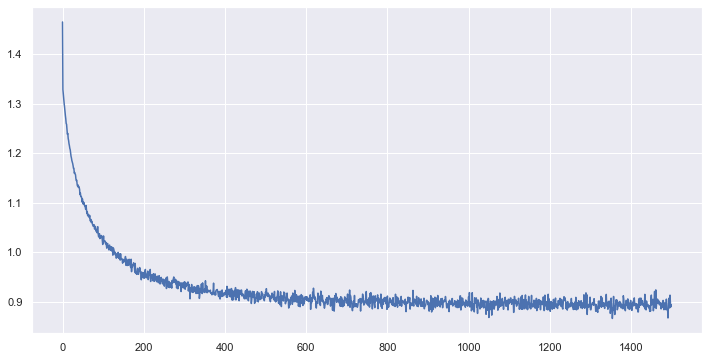

0.8154421698015172 0.8078927441984767
True Positives:0.3426	True Negatives:0.4728
False Positives:0.0731	False Negatives:0.1115
Accuracy:0.8154
Recall:0.7545	Precision:0.8243
f1 measure:0.7878


In [42]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l2_penalty = 0.000, n_batches=1)

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

Посмотрим веса

<BarContainer object of 4 artists>

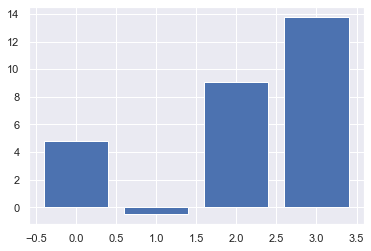

In [43]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)

Проведем тест с регуляризацией L2

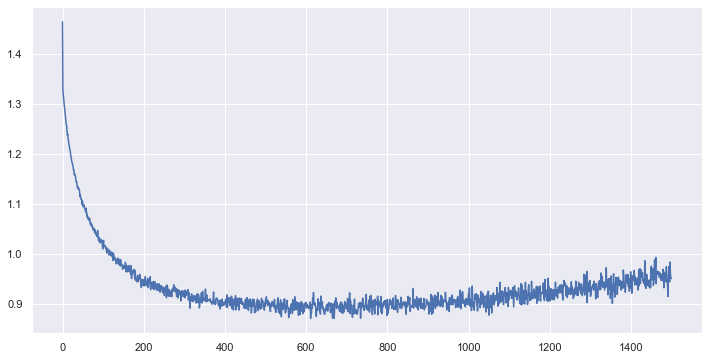

0.8135716512522082 0.8049084673288495
True Positives:0.3537	True Negatives:0.4598
False Positives:0.0860	False Negatives:0.1004
Accuracy:0.8136
Recall:0.7789	Precision:0.8043
f1 measure:0.7914


In [44]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l2_penalty = 0.0003, n_batches=1)

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

<BarContainer object of 4 artists>

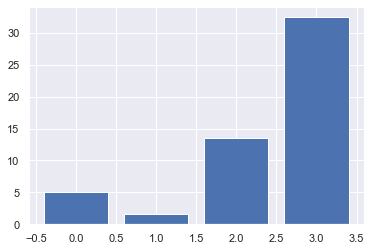

In [45]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)

Проведем тест с L1 регуляризацией

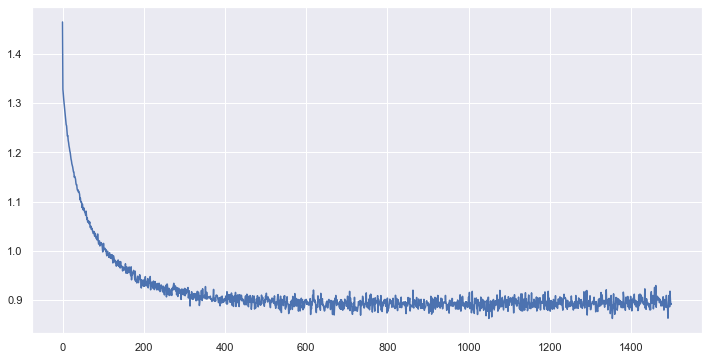

0.8170009352592746 0.808605407331522
True Positives:0.3475	True Negatives:0.4695
False Positives:0.0764	False Negatives:0.1066
Accuracy:0.8170
Recall:0.7652	Precision:0.8198
f1 measure:0.7916


In [46]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.005, n_batches=1)

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

<BarContainer object of 4 artists>

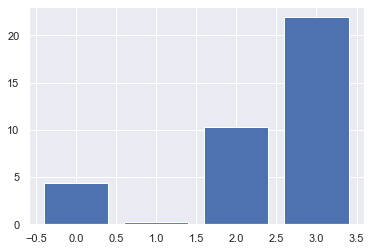

In [47]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)

Эластичная регрессия

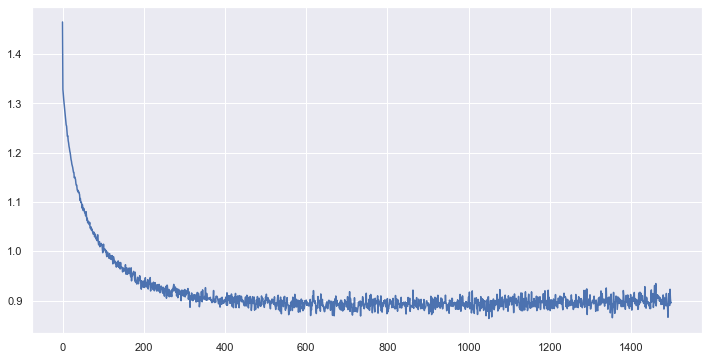

0.8163774290761717 0.8078927441984767
True Positives:0.3485	True Negatives:0.4678
False Positives:0.0780	False Negatives:0.1056
Accuracy:0.8164
Recall:0.7675	Precision:0.8171
f1 measure:0.7915


In [48]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.005, l2_penalty = 0.00003, n_batches=1)

regr.fit(X_train, y_train)

regr.plot_cost()

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

<BarContainer object of 4 artists>

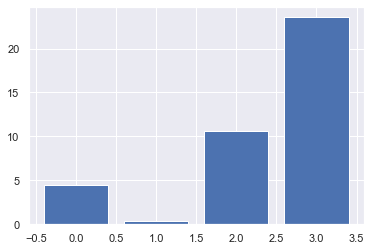

In [49]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)

### Вопрос
1. Во всех приведенных выше примерах видно, что один из параметров практически не используется для классификации, ответьте какой среди анализируемых столбцов.


Посмотрим, можно ли проводить классификацию без излишнего параметра.

In [50]:
w, b = regr.get_w_and_b()

w[1] = 0

regr = LogisticRegression(learning_rate=0.8,
                          epochs=1500,
                          batch_size=5000, 
                          l1_penalty = 0.005,
                          weights = w,
                          bias = b, 
                          n_batches=1)

print(regr.score(X_test, y_test), regr.score(X_train, y_train))

regr.classification_report(X_test, y_test)

0.8144029928296789 0.808204534319184
True Positives:0.3389	True Negatives:0.4755
False Positives:0.0704	False Negatives:0.1152
Accuracy:0.8144
Recall:0.7462	Precision:0.8281
f1 measure:0.7850


### Вопрос
1. Назовите параметр, который в наибольшей степени связан с целевой переменной.


## Метод главных компонент


Метод главных компонент - это метод снижения размерности данных путем преобразования их в такую форму, чтобы оставить только максимально полезную информацию. Метод работает без учителя, поэтому под термином полезная информация в данном методе понимается набор независимых друг от друга признаков с максимальной дисперсией (с максимальным разбросом значений). При этом мы изначально полагаем, что интенсивность (в некотором смысле) полезной информации преобладает над интенсивностью каких-то случайных искажений или других не идеальностей нашего набора данных. Для выделения полезной информации в методе главных компонент проводится преобразование данных от набора исходных столбцов (исходных признаков), которые могут содержать шумы и быть линейно зависимыми к набору новых столбцов, которые обладают важным свойством линейной независимости (не коррелируют). Такие новые столбцы можно изобразить как некоторую систему координат, в которых можно отложить точки - наши данные. При этом часто оказывает так, что некоторые из координат не нужны - в них почти наверняка нет информации. Это можно представить, как если мы возьмём двухмерную фигуры и будем строить ее в трехмерной плоскости. При этом окажется, что можно выбрать такую систему координат, что третья ось не нужна. При этом даже если мы возьмём трехмерную цельную фигуры, но по одной из осей у нас будет "совсем чуть-чуть", то можно рассмотреть этот случай как двухмерный. В нашем примере две оси, в которых будет основная часть фигуры будут главными компонентами. Совокупность наших главных компонент образует т.н. собственное подпространство. Третья ось останется т.н. шумовым подпространством. Как видно из примера размерность фигуры в каждой из обозначенных осей будет соответствовать важности этой оси. Другими словами, можно сказать что разброс значений в каждой оси будет соответствовать ее важности. Такой разброс значений по каждой оси будет называться - собственные значения. Сортируя собственные значения по убыванию, мы можем определить те из них, которые следует оставить и те, которые следует убрать. Цель Метода Главных компонент найти и отбросить шумовое подпространство.

Классический метод главных компонент состоит из следующих операций:
1.	вычисление ковариационной матрицы для набора данных - то есть матрицу дисперсий.
2.	вычисление (поиск) собственных векторов и их собственных значений по ковариационной матрице.
3.	сортировка собственных значений по убыванию.
4.	выделения собственного подпространства.
5.	преобразование данных - построение проекции исходного массива на полученные собственные вектора.

1-4 операции будут реализованы функцией `fit` последняя операция будет реализована функцией `transform`. Также нами будет реализована операция `inverse_transform`, необходимая для восстоновления исходного набора данных. Важно отметить, что на практике такое восстановление может быть не точным так как сокращая разность данных вы можете удалить оттуда и часть полезной информации. Оценку точности восстоновления можно провести по метрике $R_2$, которая обсуждалась выше.

Отметим, что известно, что собственные вектора и собственные значения для некоторой квадратной матрицы $A$ удовлетворяют следующему уравнению:
$$A\vec{V}_i = \lambda_i\vec{V}_i,$$
где $\vec{V}_i$ - это собственный вектор; $\lambda_i$ - соответствующее собственное значение. По сути выражение выше представляет собой решение системы линейных уравнений с параметром $\lambda_i$. Значения данного параметра можно найти из следующего выражения:
$$ det(A-\lambda_I) = 0, $$
где $det$ - операция поиска определителя матрицы, а $\lambda_I$ - диагональная матрица с собственными значениями по главной диагонали и нулями в остальных позициях. При раскрытие операции детерменент по определению данное уравнение может быть сведено к поиску корней полнинома.





In [51]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.values = None
        self.mean = None
    
    #--------------------------------    
    def fit(self, X):

        self.mean = np.mean(X, axis=0)
        
        # decomposition of the covariance function
        cov_matrix = np.cov(X - self.mean, rowvar = False)
        
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        idx = eigenvalues.argsort()[::-1] #the highest values
        
        # eigen sub-space is the first n eigenvectors
        self.components = eigenvectors[:, idx][:, :self.n_components]
        self.values     = eigenvalues[idx]
        
        return self
    
    #--------------------------------
    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.components)
    #--------------------------------
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    #--------------------------------
    def inverse_transform(self, X_new):
        return np.dot(X_new, self.components.T) + self.mean
    #--------------------------------
    def score(self, X):
        SStot = np.sum(np.square(X - np.mean(X)))
        SSres = np.sum(np.square(X - self.inverse_transform(self.fit_transform(X))))
        return 1 - SSres/SStot
    #--------------------------------
    def plot_eigvalues(self, figsize=(12,4)):
        plt.figure(figsize=figsize)
        plt.plot(self.values, label='all eigvalues')
        plt.plot(self.values[:self.n_components],'-o', label='eigen subspace')
        plt.title('eigenvalues');plt.legend();plt.show()
    


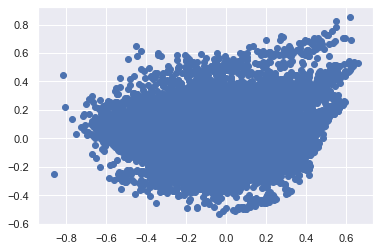

eigenvalues [0.04203692 0.01886132 0.01399888 0.00369163]


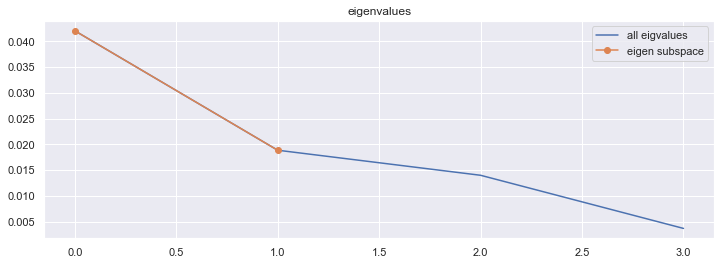

score: 0.9403754785630425


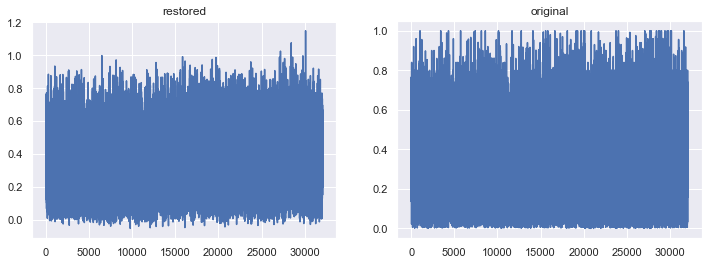

In [52]:

scaler = MinMaxScaler()
X = scaler.fit_transform(df_num)

pca = PCA(n_components = 2)
pca.fit(X)
X_new = pca.transform(X)
plt.scatter(X_new[:,0], X_new[:,1]); 
plt.show()

print('eigenvalues',pca.values)
pca.plot_eigvalues()

print('score:',pca.score(X))

X2 = pca.inverse_transform(X_new)
plt.figure(figsize=(12,4))
plt.subplot(121);plt.plot(X2[:,1]);plt.title('restored')
plt.subplot(122);plt.plot(X[:,1]);plt.title('original')
plt.show()


Проверим полный набор  данных

In [53]:
df_se = pd.read_csv("car_se.csv")
df_se = df_se.drop(columns = ['Unnamed: 0'])
df_se.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32074 entries, 0 to 32073
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  32074 non-null  int64  
 1   Model                 32074 non-null  int64  
 2   Year                  32074 non-null  int64  
 3   Style                 32074 non-null  int64  
 4   Distance              32074 non-null  float64
 5   Engine_capacity(cm3)  32074 non-null  float64
 6   Fuel_type             32074 non-null  int64  
 7   Transmission          32074 non-null  int64  
 8   Price(euro)           32074 non-null  float64
 9   km_year               32074 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 2.4 MB


In [54]:
from sklearn.decomposition import PCA

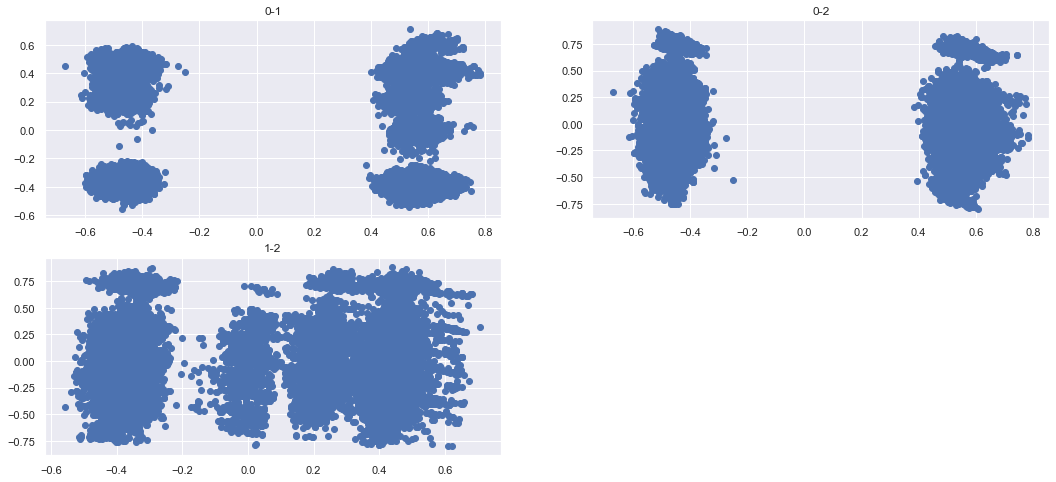

score: 0.6432876632432467


In [56]:
scaler    = MinMaxScaler()
X_cluster = scaler.fit_transform(df_se)
pca = PCA(n_components=3)

X_new = pca.fit_transform(X_cluster)
X_new.shape

plt.figure(figsize=(18,8))
plt.subplot(221); plt.scatter(X_new[:,0],X_new[:,1]); plt.title("0-1")
plt.subplot(222); plt.scatter(X_new[:,0],X_new[:,2]); plt.title("0-2")
plt.subplot(223); plt.scatter(X_new[:,1],X_new[:,2]); plt.title("1-2")
plt.show();

print('score:',pca.score(X_cluster))




### Вопрос:
1. назовите значение точности преобразования (и Восстановления) методом главных компонент, если дисперсия данных 0.4, а дисперсия остатков восстановления по главным компонентам 0.1   <br>


## Кластеризация k-средних

В ряде случаев при анализе данных оказывается так, что про данные ничего не известно, однако хочется понять на сколько они однородны или, например, могут быть разделены на группы. Такие группы можно назвать кластерами. Задача разделения на кластеры не требует наличия учителя. Другими словами, мы пытаемся найти закономерности в данных как таковых без привязки к тому, какие результаты для них мы хотим получить.<br>

 Одним из самых простых методов кластеризации является метод k-средних.
Суть данного метода сводится к тому, чтобы найти заданное число кластеров (k) и их центры (т.н. центроиды) таких, чтобы расстояние от центроидов до всех точек кластера было минимальным.

Алгоритм k-средних может быть описан следующим образом <ul>
<li>выбирается к случайным точкам - центроиды.
<li>рассчитывается вектор расстояние между каждой точкой набора данных и каждым центроидом.
<li>в каждый кластер записываются те точки для которых оказалось, что для соответствующего центроида расстояние меньше, чем для других.
<li>новые значение центроидов рассчитываются как среднее значение по всем точкам кластера.


In [57]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_num)
X.shape

(32074, 4)

Рассчитаем расстояние как сумму разностей квадратов.

In [58]:
def distance(X1, X2):
    return np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))

Проведем несколько тестов, функция работает как с векторами, так и матрицами равной размерности.

In [59]:
print(distance(X[0], X[1]))
print(distance(X[:5], X[10:15]))
print(distance(X[0], X[10:15]))

0.14824394928129211
[0.37527846 0.60674115 0.27679969 0.15344456 0.363898  ]
[0.37527846 0.47630497 0.14707452 0.15696026 0.15360423]


### вопрос:
1. если есть три центроида С1:(1,0,0);  С2:(0,1,1) и С3:(1, 0, 1) и точка (2,0,2), к какому кластеру ее следует отнести?  <br>


Прежде чем проводить кластеризацию необходимо проинициализировать калстеры.<br>
Для этого выберем случайные индексы среди доступных в наборе данных.

In [60]:
def init_centroids(X, n_clusters):
    centroid_idxs = np.random.randint(0, X.shape[0], size = n_clusters)
    return X[centroid_idxs,:]


посмотрим как это работает для двух кластеров

In [61]:
n_clusters = 2
centroids = init_centroids(X, n_clusters)
print(centroids)

[[0.8        0.42778756 0.27083333 0.06912826]
 [0.54       0.39987998 0.29166667 0.01803607]]


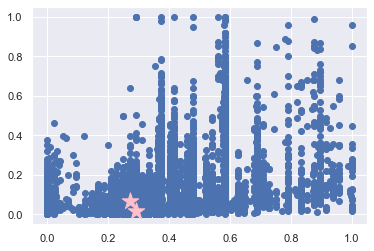

In [62]:
plt.scatter(X[:, 2], X[:, 3])
plt.scatter(centroids[:, 2], centroids[:, 3], marker='*', s=300, c='pink')
plt.show()

Проведем первую кластеризацию. Для этого возьмем каждый центроид и посчитаем расстояние от него до все записей набора данных. <br>
Индексы значений для каждого кластера выберем как индексы минимальных расстояний до соответствующего центроида. <br>
Таким образом, нулевой кластер будет включать те точки набора данных, в которых расстояние до нулевого центроида меньше, чем до первого центроида.

In [63]:
def predict(X, n_clusters, centroids):
    distances = np.zeros((X.shape[0], n_clusters))

    for i,centr in enumerate(centroids):
        distances[:,i] = distance(centr,X)

    cluster_label = np.argmin(distances,axis = 1)
    return cluster_label

посмотрим как распределились результаты кластеризации

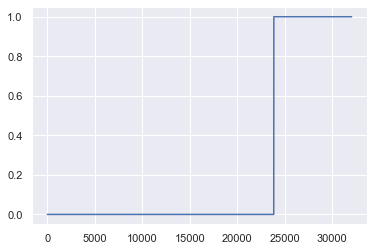

In [64]:
cluster_label=predict(X, n_clusters, centroids)
plt.plot(np.sort(np.copy(cluster_label)))

Проверим результаты первой кластеризации

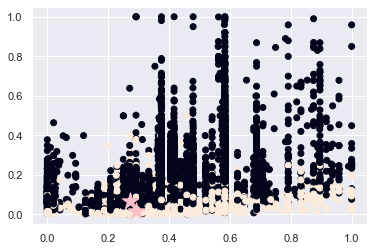

In [65]:
plt.scatter(X[:, 2], X[:, 3], c = cluster_label)
plt.scatter(centroids[:, 2], centroids[:, 3], marker='*', s=300, c='pink')
plt.show()

Теперь выберем новые центроиды, для этого нам понадобиться выбрать каждый кластер по отдельности.
<br> Новый центроид для каждого кластера выберем как среднее значение по кластеру.<br>
Расмотрим для начала пример с 0 кластером.<br>
В визуализации вы увидите старый центроид как звезду и новый как красный круг.

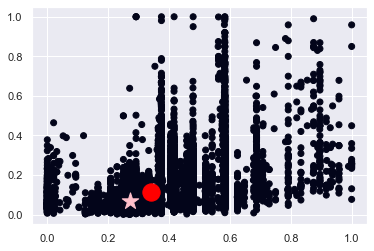

In [66]:
c_idxs = np.flatnonzero(cluster_label==0)
cluster_zero = X[c_idxs]
new_centroid = cluster_zero.mean(axis = 0)
plt.scatter(cluster_zero[:, 2], cluster_zero[:, 3], c = cluster_label[c_idxs])
plt.scatter(centroids[0, 2], centroids[0, 3], marker='*', s=300, c='pink')
plt.scatter(new_centroid[2], new_centroid[3], marker='o', s=300, c='red')

Проведем такую операцию для всех кластеров.

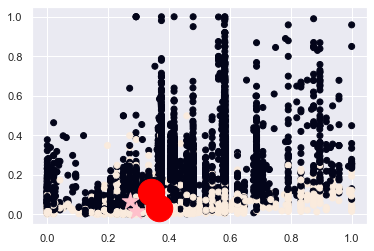

In [67]:
old_centroids = np.copy(centroids)

for k in range(n_clusters):
    c_idxs = np.flatnonzero(cluster_label==k)
    centroids[k] = X[c_idxs].mean(axis = 0)
    
plt.scatter(X[:, 2], X[:, 3], c = cluster_label)
plt.scatter(centroids[:,2], centroids[:,3], marker='o', s=700, c='red')
plt.scatter(old_centroids[:, 2], old_centroids[:, 3], marker='*', s=300, c='pink')


Рассчитаем относительное расстояние между старыми и новыми центроидами. Если расстояние между обновленными центроидами будет сравнительно небольшим - то есть центроиды перестанут менять позицию, то мы будем считать что кластеризация закончена.

In [68]:
def delta_centroids(centroids,old_centroids):
    return (distance(centroids,old_centroids)/distance(old_centroids, np.mean(old_centroids))).mean()

delta_centroids(centroids,old_centroids)

0.2262081455458366

Попробуем создать процедуры итерационной кластеризации. В кноце процедуры выведем результирующий номер итерации и расстояние между кластерами

In [69]:
def fit(X, n_clusters, centroids, max_iter=10, tol=0.01):
    
    dcentr = np.inf
    
    for i in range(max_iter):
        
        old_centroids = np.copy(centroids)
        cluster_label=predict(X, n_clusters, centroids)
        
        for k in range(n_clusters):
            c_idxs = np.flatnonzero(cluster_label==k)
            centroids[k] = X[c_idxs].mean(axis = 0)
        
        dcentr = delta_centroids(centroids,old_centroids)
        
        if dcentr<=tol:
            break
    
    print('stop on iter:', i,'with relative distance change: ',dcentr)
            
    return cluster_label

проверим и визуализируем результаты:

In [70]:
old_centroids = np.copy(centroids)

cluster_label = fit(X, n_clusters, centroids, max_iter=100, tol=0.001)

stop on iter: 7 with relative distance change:  0.000834698903976455


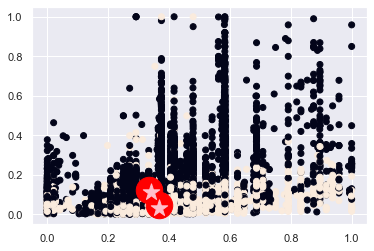

In [71]:
plt.scatter(X[:, 2], X[:, 3], c = cluster_label)
plt.scatter(centroids[:,2], centroids[:,3], marker='o', s=700, c='red')
plt.scatter(old_centroids[:, 2], old_centroids[:, 3], marker='*', s=300, c='pink')

Теперь объеденим все наши наработки в один класс.

In [72]:
class KMeans():
    def __init__(self,n_clusters = 2, centroids = None, max_iter=10, tol=0.01):
        self.n_clusters = n_clusters
        self.centroids  = centroids
        self.max_iter   = max_iter        
        self.tol        = tol
        self.iters      = None
    #-------------------------------------    
    def distance(self, X1, X2):
        return np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
    #-------------------------------------
    def init_centroids(self, X):
        c_idxs = np.random.randint(0, X.shape[0], size = self.n_clusters)
        return X[c_idxs,:]
    #-------------------------------------
    def predict(self, X):
        distances = np.zeros((X.shape[0], self.n_clusters))

        for i,centr in enumerate(self.centroids):
            distances[:,i] = self.distance(centr,X)

        return np.argmin(distances,axis = 1) # cluster label
    #-------------------------------------
    def delta_centroids(self,old_centroids):
        return (
                distance(self.centroids,old_centroids)/
                distance(old_centroids, np.mean(old_centroids))
               ).mean()
    #-------------------------------------
    def fit(self, X):
        
        if self.centroids is None:
            self.centroids = self.init_centroids(X)
    
        d_centrs = np.inf

        for i in range(self.max_iter):

            old_centroids = np.copy(self.centroids)
            
            cluster_label = self.predict(X)

            for k in range(self.n_clusters):
                
                c_idxs = np.flatnonzero(cluster_label==k)
                
                self.centroids[k] = X[c_idxs].mean(axis = 0)

            d_centrs = self.delta_centroids(old_centroids)

            self.iters = i
            if d_centrs<=self.tol:
                break
        return self        
    #-------------------------------------
    def fit_transform(self, X):
        return self.fit(X).predict(X)
    
    

Проверим как это работает. Отметим, что в данном примере мы проведем кластеризацию на двух-мерной выборке данных. Это будет правильней с точки зрения визуализации.

stop on iter: 27


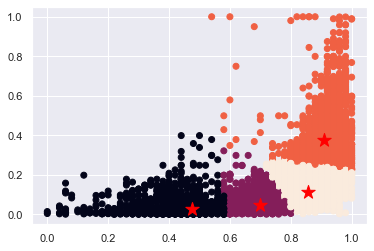

In [73]:
kmeans   = KMeans(n_clusters=4, max_iter=1000, tol=0.0001)
c_labels = kmeans.fit_transform(X[:,[0,3]])

print('stop on iter:',kmeans.iters)

plt.scatter(X[:, 0], X[:, 3], c = c_labels)

plt.scatter(kmeans.centroids[:,0], kmeans.centroids[:,1],marker='*', s=200, c='red')

Также проверим результаты для резуьтата сжатия размерности методом главных компонент набора данных `df_se`

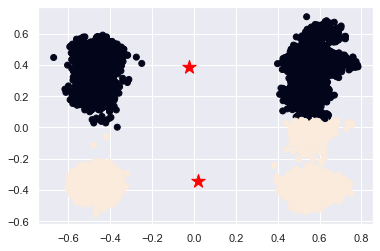

stop on iter: 14


In [74]:
scaler    = MinMaxScaler()
X_cluster = scaler.fit_transform(df_se)

pca = PCA(n_components=2)

X_new = pca.fit_transform(X_cluster)

kmeans   = KMeans(n_clusters=2, max_iter=1000, tol=0.00001)
c_labels = kmeans.fit_transform(X_new)

plt.scatter(X_new[:,0],X_new[:,1], c = c_labels);
plt.scatter(kmeans.centroids[:,0], kmeans.centroids[:,1],marker='*', s=200, c='red')
plt.show();
print('stop on iter:',kmeans.iters)

### Задача 1

1. Добавьте к регрессииям метод стохастического градиентного спуска с моментом, который,  в самом простом случае может быть выражен следующим правилом обновления весовых пареметров:
$$W^t = \beta W^{t-1} - \eta \nabla_W L + (1-\beta) W^{t-2}, $$
где $\beta < 1$.

Проверьте результаты для линейных и логистических регрессий



2. Реализуйте Метод нестерова для стохастического градиентного спуска. 
<blockquote>
    Для получения данного выжраения следует ввести понятие скорость спуска:
    $$ V^t = \Delta W^t = W^{t}-W^{t-1}$$
    Введем новую переменную:
    $$ \gamma = \beta-1 \to \beta = 1+\gamma $$
    Теперь запишим при помощи новой переменной выжрение для градиентного спуска с моментом:
    $$W^t =  W^{t-1} + \gamma W^{t-1} - \eta \nabla_W L - \gamma W^{t-2} $$
    Теперь запишим выражение для спуска с моментом, при помощи новых понятий:
    $$ \begin{cases}
    W^{t} = V^t +W^{t-1}
    \\
    V^t = \gamma V^{t-1} - \eta \nabla_W L(W^{t-1},X,y)
    \end{cases}
    $$
    Теперь допустим, что для обновления весовых значений скорости мы хотим вычислить градиент не в точке $W^{t-1}$, а в точке немного смещнной в направлении спуска градиента, то есть в точке $W^{t-1} - \gamma V^{t-1}$. Использование такого приема для метода градиентного спуска с моментном приводит к т.н. методу Нестерова:
   $$ \begin{cases}
    W^{t} = V^t +W^{t-1}
    \\
    V^t = \gamma V^{t-1} - \eta \nabla_W L(W^{t-1}-\gamma V^{t-1},X,y)
    \end{cases}
    $$ Предполагается, что такой метод должен обеспечить более быстрое схождение.
</blockquote>
Запишим метод Нестерова в виде одного выражения:
$$W^t = \beta W^{t-1} + (1-\beta) W^{t-2} - \eta \nabla_W L\left(\beta W^{t-1} + (1-\beta) W^{t-2} \right) , $$
    
    
Сравните  результаты для градиентного спуска без моментов, градиентного спуска с моментом и мтеода Нестерова для линейных и логистических регрессий (на практике как правило $\beta\approx\gamma\approx0.9$ ).

### Задача 2 
Добавьте к алгоритму логистической регрессии возможность обрабатывать категориальные данные как таковые.

### Задача 3
Добавьте к алгоритму метода главных компонент возможность выбора относиетльного числа компонент (например 25%) от всех возможных.

### Задача 4
Добавьте к алгоритму кластеризации условие обучения: среднее расстояние между центроидом и его кластером меньше, чем между двумя центроидами (условия не попадания одного центриода в кластер другого в среднем).

### Дополнительное (но не обязательное) задание
сравните методы градиентного спуска, изученне ранее со следующими популярными методами:

RMSprop:$$
\begin{cases} 
EG^{t} = \beta \left[\nabla_W L\right]^2 + (1-\beta) EG^{t-1} \\ 
W^{t} = W^{t-1} - \eta\frac{1}{\sqrt{EG^{t} + \epsilon}} \nabla_W L
\end{cases} $$
Как правило, $\beta \approx 0.9; \eta \approx 10^{-3}.$

ADAM:
$$ 
\begin{cases} 
EG_1^{t} = \beta_1 \left[\nabla_W L\right] + (1-\beta_1) EG_1^{t-1} \\ 
EG_2^{t} = \beta_2 \left[\nabla_W L\right]^2 + (1-\beta_2) EG_2^{t-1} \\
W^{t} = W^{t-1} - \eta\frac{EG_1^t}{\sqrt{EG_2^{t} + \epsilon}} \nabla_W L
\end{cases} 
$$
Как правило, $\beta_1 = 0.9, \beta_2 = 0.99, \eta = 3\cdot 10^{-4}.$

<!--https://ruder.io/optimizing-gradient-descent/index.html#fn7
https://stepik.org/lesson/193593/step/12?unit=168011 -->